### <center> **Bootstrapping using Chain Ladder method**
---

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from chain_ladder import *
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# 0. import data
sheet_name = input("sheet name:")

X_triangle = import_triangle("triangles.xlsx", sheet_name, "triangle") # incremental observed triangle
Y_triangle = to_cum_triangle(X_triangle) # cumulative observed triangle
print(X_triangle)

t = X_triangle.shape[0] # number of acc./dev. years
n = int(t*(t+1)/2) # number of elements in the upper triangle
p = 2*t-1 # number of parameters to estimate

sheet name: CAS


          1          2          3         4        5
1   7017487 4151522.00  999910.00 215639.00 52760.00
2   8954484 5091234.00 1037206.00 336748.00      NaN
3   9155776 6215702.00 1086998.00       NaN      NaN
4  10394069 6190043.00        NaN       NaN      NaN
5  12755243        NaN        NaN       NaN      NaN


In [3]:
# 1. development factors (chain ladder)
M_table = gen_adj_table(Y_triangle)

# 2. adjusted cumulative upper triangle (and loss reserve)
M_triangle = to_triangular_form(M_table)
_, ibnr = calculate_loss(M_triangle, 1) # IBNR by AY (assumes tail factor = 1)
R = ibnr.sum() # total IBNR

# 3. adjusted incremental upper triangle 
m_triangle = to_inc_triangle(M_triangle)
print(m_triangle)

            1          2          3         4        5
1  7003006.77 4267929.29  867577.77 246044.18 52760.00
2  8719250.81 5313881.19 1080197.18 306342.82 65690.02
3  9495299.05 5786837.90 1176339.05 333608.56 71536.70
4 10304259.38 6279852.62 1276558.29 362030.64 77631.33
5 12755243.00 7773585.98 1580201.99 448143.68 96096.81


In [4]:
# 4.1 Pearson residuals
r_triangle = (X_triangle - m_triangle) / np.sqrt(m_triangle) 
residuals = r_triangle.values.flatten()
residuals = residuals[~np.isnan(residuals)] # 1D array

phi = (residuals**2).sum()/(n-p) # scale parameter

# 4.2 Adjusted pearson residuals
r_triangle = r_triangle*np.sqrt(n/(n-p)) 
aj_residuals = r_triangle.values.flatten()
aj_residuals = aj_residuals[~np.isnan(aj_residuals)] # 1D array

print(r_triangle)
print(f"\nScale parameter: {round(phi,4)}")

        1       2       3      4    5
1    8.65  -89.09  224.64 -96.92 0.00
2  125.96 -152.71  -65.40  86.86  NaN
3 -174.21  281.88 -130.24    NaN  NaN
4   44.24  -56.67     NaN    NaN  NaN
5    0.00     NaN     NaN    NaN  NaN

Scale parameter: 16721.1357


In [5]:
# 5. Bootstrap loop
iterations = 1000
results = []
for i in range(iterations):
    # 5.1 bootstrap sample of the residuals (upper triangle form)
    boot_sample = pd.DataFrame(np.nan, index=range(1,t+1), columns=range(1,t+1))
    for row in boot_sample.index:
        for col in boot_sample.index:
            if row+col<=t+1:
                boot_sample.loc[row,col] = np.random.choice(aj_residuals)
            else: pass

    # 5.2 upper pseudo incremental values
    Xpseudo_triangle = boot_sample*np.sqrt(m_triangle)+m_triangle

    # 5.3 upper pseudo cumulative values
    Ypseudo_triangle = to_cum_triangle(Xpseudo_triangle)

    # 5.4 estimate lower pseudo cumulative triangle w/ chain ladder
    Mpseudo_table = gen_adj_table(Ypseudo_triangle)
    Mpseudo_triangle = to_triangular_form(Mpseudo_table) # estimated cumulative triangle

    # 5.5 estimated lower pseudo incremental triangle
    mpseudo_triangle = to_inc_triangle(Mpseudo_triangle)

    # 5.6 generate random values from process distribution (gamma)
    mgamma_triangle = mpseudo_triangle.apply(lambda m: np.random.gamma(shape=m/((m*phi**2)/m),
                                                                       scale=(m*phi**2)/m
                                                                      )
                                            )

    # 5.7 compute IBNR by AY
    _, ibnr = calculate_loss(to_cum_triangle(mpseudo_triangle))

    # 5.7 store the results and go back to step 5.1
    results.append(ibnr.sum())

results = np.array(results)

Bootstrap distribution presents the following statistics: 
	- mean: 12094508.5
	- sample size: 1000
	- standard deviation: 598069.32 
	- variance: 357686916799.55 
	- standard error: 598069.32

Quantiles: 
	- min: 10291227.31
	- 1st-Q: 11668038.05
	- median: 12065681.97
	- 3rd-Q: 12488908.29
	- max: 14412488.66



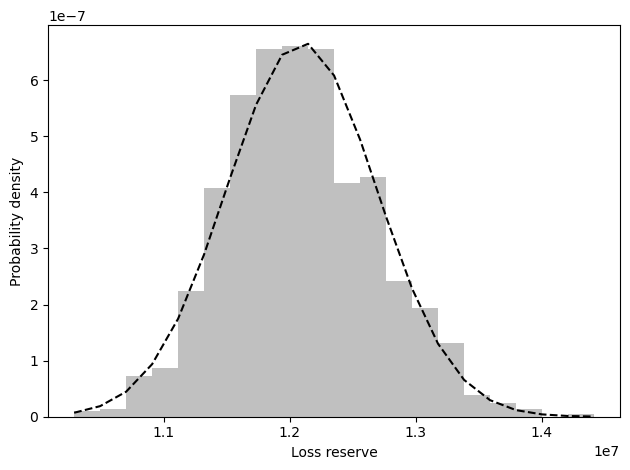

Bootstrap estimated loss reserve is 12094508.504, with 9424.4966 bias from Chain Ladder method (12085084.0074).

Variability measures for our estimates: 
	- process variance: 202076329056.3412
	- estimation variance: 894217291.9989
	- cuadratic mean error: 202970546348.34
	- prediction error: 450522.5259 



In [6]:
# bootstrap distribution analysis

# statistics
mean = results.mean()
std = results.std()
var = std**2
size = results.shape[0] 
se = std/np.sqrt(size)

print(f"""Bootstrap distribution presents the following statistics: 
\t- mean: {round(mean,2)}
\t- sample size: {size}
\t- standard deviation: {round(std,2)} 
\t- variance: {round(var,2)} 
\t- standard error: {round(std,2)}
""")

print(f"""Quantiles: 
\t- min: {round(results.min(),2)}
\t- 1st-Q: {round(np.quantile(results, 0.25),2)}
\t- median: {round(np.median(results),2)}
\t- 3rd-Q: {round(np.quantile(results, 0.75),2)}
\t- max: {round(results.max(),2)}
""")

# histogram
fig, ax = plt.subplots()

num_bins, mu, sigma = 20, mean, std
_, bins, patches = ax.hist(results, num_bins, density=True, color="silver") # histogram

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2)) # best normal fit

ax.plot(bins, y, '--', color="black")
ax.set_xlabel('Loss reserve')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of IBNR: $\mu$={round(mu,2)}, $\sigma$={round(sigma,2)}')

#plt.savefig('bootCL_hist.png')
fig.tight_layout()
plt.show()


# estimates and variability measures
bias = mean - R
print(f"Bootstrap estimated loss reserve is {round(mean,4)}, with {round(bias,4)} bias from Chain Ladder method ({round(R,4)}).")

var_process = phi*R
var_estimations = n/(n-p)*se**2
cme = var_estimations+var_process
pe = np.sqrt(cme)

print(f"""\nVariability measures for our estimates: 
\t- process variance: {round(var_process,4)}
\t- estimation variance: {round(var_estimations,4)}
\t- cuadratic mean error: {round(cme,4)}
\t- prediction error: {round(pe,4)} 
""")

In [7]:
#pd.DataFrame(results, columns=["IBNR-chain"]).to_excel("resultados_boot_cl.xlsx", index=False)

---